# Making Good Use of Your Data 

In our previous exercises, we have seen how the choice of network architecture and training hyper-parameters can help us improve our classification accuracy.

During this part of the course we will see how the quality of our dataset also plays a paramount role in solving machine learning tasks.

More specifically, we will see how to overcome some real world issues such as lack of data variability.

For this practical, we will go back to using the ResNet9 architecture. We will see how the performance can reach ~91% by simply improving the dataset.

# Data Augmentation

If we think about it, classification is essentially the task of choosing a set of features that are shared among all elements within a class, while ignoring features that make each element unique. In other words, we want to ignore features that should not be relevant to our task. 


As we have seen earlier, Convolutional Neural Networks rely on key ideas such as weight sharing and locality that ultimately lead to equivariance to translation. That is, convolutions enable a network to say that two objects are the same regardless of where they appear in the image. A cat on the top right of an image is still a cat in the bottom left part of the image.  

However, depending on the task in hand, there are still other properties besides translation that we'd like for our network to *ignore* such as, for example, slight change in color, partial occlusion, etc... 

Is a vertically flipped cat still a cat? What about a rotated cat? 

No two cats are the same, but they are still cats despite their size, fur color, and pose. 

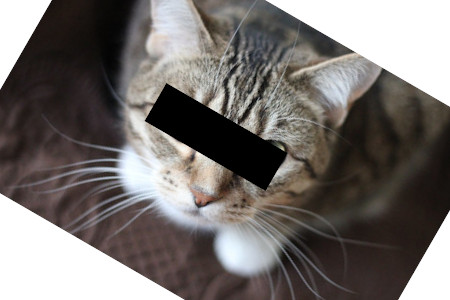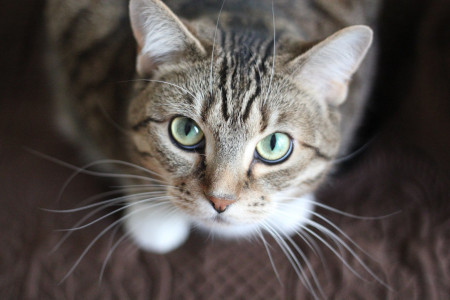

Unfortunately, convolutions are not perfectly designed to deal with those variations, but we can still exploit this knowledge during training.

We do so in a process called *Data Augmentation* where we generate *new* data by applying those exact variations directly to the input data.

PyTorch provides a series of transformations to augment data during data loading. 

During this practical, we will look into some of the most common data augmentation transformations and see the effect they have on classification accuracy. You can find more about Torchvision transforms on [PyTorch Documentation](https://pytorch.org/docs/stable/torchvision/transforms.html).



## Dataset Processing in PyTorch

As we have seen earlier, before we begin to train our network, we need to choose a dataset, which in PyTorch is implemented by the [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class. 

A Dataset retrieves and *pre-processes* data so that it will be ready to be passed to the network during either training, test or inference.

When working with images, *pre-processing* is done using [TorchVision Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html), which you might recall from previous practicals. 

In fact, we have been using them to (1)normalise data from MNIST and (2) transform data it into PyTorch tensors as seen in the code below. 

```
transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
```

During the first part of this Practical we will focus on choosing the right *transforms* that will augment our dataset and improve our *testing* accuracy.

We will begin by defining our Network Baseline which will just normalise data and transform it into PyTorch tensor.


### Network Baseline
In order to see the effects of each tranformation, we will first measure the accuracy of a ResNet-9 on CIFAR10 using only data normalization. This will serve as our baseline. 

The code below will download ResNet-9 and define some helper functions for training. Don't worry about them too much. 

Go ahead and *run* these first cells and just make sure that you understand what the **main** function below is doing.

In [ ]:
!git clone https://github.com/mackopes/DNN_Practicals_Extras.git extras

In [ ]:
import os
import random
import urllib.request

import extras.p05_p09.miscFuncs as misc

In [ ]:
# Helper functions

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tensorboard import notebook

def run_seq_batches(model, writer, epoch, batches, training, n_iter, optimizer_step=None, stats=None, logStep = 25, isTest = False):
    stats = stats or StatsLogger(('loss', 'correct'))
    model.train(training)

    if training:
      with tqdm(total=len(batches)*batches.batch_size, desc='Train Epoch #' + str(epoch)) as t:
        for i, data in enumerate(batches):
          inputs, labels = data
          batch = { 'input': inputs.cuda().half(),
            'target': labels.cuda() }
          output = model(batch)
          stats.append(output)
          
          output['loss'].sum().backward()
          optimizer_step()
          model.zero_grad()
          t.set_postfix({'avgAcc':'{:05.3f}'.format(stats.mean('correct')), 'avgLoss':'{:05.3f}'.format(stats.mean('loss'))})
          t.update(batches.batch_size)

          if i % logStep == 0:
            # Compute accuracy and write values to Tensorboard
            writer.add_scalar('train/loss', stats.mean('loss'), n_iter)
            writer.add_scalar('train/acc', stats.mean('correct'), n_iter)
          n_iter += batches.batch_size
    else:
        for data in batches:
          inputs, labels = data
          batch = { 'input': inputs.cuda().half(),
                 'target': labels.cuda() }
          output = model(batch)
          stats.append(output)
        if isTest:
          writer.add_scalar('test/acc', stats.mean('correct'), 0)
          print("Test Accuracy:", stats.mean('correct'))
        else:
          writer.add_scalar('val/acc', stats.mean('correct'), n_iter)
          writer.add_scalar('val/loss', stats.mean('loss'), n_iter)

    return n_iter

def run_train(model, writer, optimizer, train_batches, validation_batches, epochs):
    n_iter = 0
    for epoch in range(1, epochs+1):
        run_seq_batches(model, writer, epoch, validation_batches, False, n_iter) # validation step
        n_iter = run_seq_batches(model, writer, epoch, train_batches, True, n_iter, optimizer.step) # train step

def run_test(model, writer, test_batches):
    print("Evaluating test set")
    run_seq_batches(model, writer, -1, test_batches, training=False, n_iter= 0, isTest=True)



#### Main function 

In [ ]:
from extras.p05_p09.core import *
from extras.p05_p09.torch_backend import *
import extras.p05_p09.ResNet9Funcs as ResNet9
import extras.p05_p09.miscFuncs as misc

batch_size = 512
epochs = 10

def main(epochs, batch_size, train_loader, val_loader, test_loader, name_transf):
       
    # Create directory to store TensorBoard checkpoints
    writer = misc.createTensorBoardWriter('./results/p09/ResNet9_'+ name_transf)   
          
    # Construct the model
    model = ResNet9.getModel()
    
    # Scheduler  
    lr_schedule = PiecewiseLinear([0, 3, epochs], [0, 0.4, 0])
    lr = lambda step: lr_schedule(step/len(train_loader))/batch_size
    
    # Define optimizer
    optim = SGD(trainable_params(model), lr=lr, momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
    
    # Train
    run_train(model, writer, optim, train_loader, val_loader, epochs)

    # Evaluate on test set
    run_test(model, writer, test_loader)
    
    writer.close()


#### Using Dataset Transform compositions
We now define a transform compose that will only perform normalisation and image-to-tensor transform. 

In [ ]:
# Applying dataset normalization.
data_norm_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])


The following piece of code will download the CIFAR10 dataset and split it into *training*, *validation* and *test* dataset. 

Notice that we pass our composed transform inside the **torchvision.datasets.CIFAR10** request, so that ***each dataset will already know the set of transformations to be used***. 

Dataloaders (**torch.utils.data.DataLoader()**), are only responsible for loading the data.

Run the code and observe the final *test accuracy* below.

In [ ]:
# Setting fixed seed for random generator so that results are reproducible
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Splitting original data into train (90%) and validation (10%) used for our current transform.
path_to_data = './datasets'
validation_fraction = 0.1 

###
# Define the train dataset, with original transform. NOTICE THE TRANSFORM HERE :) 
train_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=data_norm_transform)
###

num_train = len(train_dataset)
split = int(np.floor(validation_fraction * num_train))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[num_train - split,split])

###
# Define test dataset, with original transform. NOTICE THE TRANSFORM HERE :) 
test_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=False, download=True, transform=data_norm_transform)
####

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

main(epochs, batch_size, train_loader, val_loader, test_loader, 'data_norm_transform')

#### Tensorboard
Let's visualise the training...

In [ ]:
%load_ext tensorboard

In [ ]:
# Visualize TENSORBOARD

%tensorboard --logdir results/p09/

### Random Horizontal Flips

Take a look at the [TorchVision Documentation](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip)  to find out what RandomHorizontalFlip does and how to include it in your composition.

# **Complete the code below** to reflect your new transform composition. 

Hint: For the CIFAR10 dataset the mean is `(0.4914, 0.4822, 0.4465)` and the standard deviation is `(0.2023, 0.1994, 0.2010)`



In [ ]:
horizontal_flip_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

Now recreate the previous *train_dataset* to include your new horizontal_flip_transform. 

Do you need to do the same to your *test_dataset*? Why?

In [ ]:
# Redefine dataset and dataloaders for train and validation. Keep test. 
train_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=horizontal_flip_transform)
num_train = len(train_dataset)
split = int(np.floor(validation_fraction * num_train))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[num_train - split,split])

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
main(epochs, batch_size, train_loader, val_loader, test_loader, 'horizontal_flip_transform')

### Random Crops 
Now find out what the RandomCrop tries to achieve and include it in the original compose.  
Try using a padding = 4.

**Complete the code.**

In [ ]:
rand_crop_transform = transforms.Compose([
                transforms.RandomCrop(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

Run the training again using this rand_crop_transform. 

In [ ]:
# Redifine dataset and dataloeaders for train and validation. Keep test. 
train_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=rand_crop_transform)
num_train = len(train_dataset)
split = int(np.floor(validation_fraction * num_train))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[num_train - split,split])

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
main(epochs, batch_size, train_loader, val_loader, test_loader, 'rand_crop_transform')

### Random Horizontal Flips + Random Crops
Now, why not trying both? **Complete the code.**


In [ ]:
both_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

In [ ]:
# Redifine dataset and dataloeaders for train and validation. Keep test. 
train_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=both_transform)
num_train = len(train_dataset)
split = int(np.floor(validation_fraction * num_train))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[num_train - split,split])

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
main(epochs, batch_size, train_loader, val_loader, test_loader, 'both_transform')

### Discussion

Which transform compose worked best during these tests? 


### Bonus
1.   Try going through the other transforms from the API. 
Choose a few and test them. 
Just remember that CIFAR10 is made of 32x32 images when considering parameters such as cropping, etc... 
2.   Consider training for a larger number of epochs, maybe 30. Did anything change? 

